In [2]:
import math
import importlib
import networkx as nx
import numpy as np
import random
import scipy

# matplotlib setting
import matplotlib.pyplot as plt

# to print logs in jupyter notebook
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

# load GraphRicciCuravture package
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci
from sklearn.linear_model import LinearRegression

In [3]:
def G_prime(G, l_b):
    G_prime = nx.Graph()
    N_prime = len(G.nodes)
    G_prime.add_nodes_from(G)
    E_prime = []
    for n1 in range(N_prime):
        for n2 in range(N_prime):
            try:
                if nx.shortest_path_length(G, n1, n2) > l_b:
                    G_prime.add_edge(n1, n2)
            except nx.NetworkXNoPath:
                return 0
    return G_prime


def Greedy_coloring(G):
    d = nx.coloring.greedy_color(G, strategy="random_sequential")
    return d


def dimension(G, l_b_max):
    N_bs = np.zeros(l_b_max)
    l_bs = np.zeros(l_b_max)
    for l_b in range(1, l_b_max+1, 1):
        G1 = G_prime(G, l_b)
        d = Greedy_coloring(G1)
        N_b = len(set(d.values()))
        N_bs[l_b-1] = N_b
        l_bs[l_b-1] = l_b

    N_bs_log = np.log(N_bs)
    l_bs_log = np.log(l_bs)
    slope, intercept = np.polyfit(l_bs_log,N_bs_log,1)
    
    dim = -slope
    return dim

In [12]:
# Function Einstein takes, for the moment, one string, which can either be 'erdos' or 'barabasi',
# and one int, which represents the 'infrared' cutoff which the final fit has to start from
# (cutoff is set by default to 35)
# It prints the plots of the mean value and standard deviation of R_{ij}/T_{ij} and the plot of
# the fractal dimension of the graph. 
# Finally it returns (and prints) the coefficient of proportionality of the opposite of the mean 
# versus the dimension and the r squared coefficient

def Einstein(string,cutoff=35):

    mean_array = []
    std_array = []
    dimension_array = []

    check = 0

    if string == 'erdos':

        steps_erdos = np.linspace(0.01,0.99,num=99) 
    
        for t in steps_erdos:
            G = nx.erdos_renyi_graph(100,t)
            vec = [0] * len(list(G.nodes))
            for n in range(len(list(G.nodes))):
                vec[n] = random.uniform(0,1)
            for (n1,n2) in G.edges:
                G[n1][n2]["weight"] = 1
            for n in G.nodes:
                G.nodes[n]['weight'] = vec[n]
            orf = FormanRicci(G)
            #orf.set_verbose("ERROR")
            orf.compute_ricci_curvature()
            n = len(G.nodes)
            T = np.zeros((n,n))
            for n1 in G.nodes:
                for n2 in G.neighbors(n1):
                    T[n1][n2] = G[n1][n2]['weight'] + G.nodes[n1]['weight']/len(list(G.neighbors(n1))) + G.nodes[n2]['weight']/len(list(G.neighbors(n2)))
            quotient = []
            for n1 in G.nodes:
                for n2 in G.neighbors(n1):
                    if T[n1][n2] > 0.000001:
                        a = orf.G[n1][n2]['formanCurvature']
                        b = T[n1][n2]
                        quotient = np.append(quotient,[a/b])
                    else: 
                        np.append(quotient,100)
                        print('zero T detected')
            
            mean = np.mean(quotient)
            std = np.std(quotient)

            if nx.is_connected(G):
                l_b_max = nx.diameter(G)
                dim = dimension(G,l_b_max)
                dimension_array = np.append(dimension_array,dim)

            mean_array = np.append(mean_array,mean)
            std_array = np.append(std_array,std)

        fig,axs = plt.subplots(3)

        num_mean = len(mean_array)
        num_std = len(std_array)
        num_dim = len(dimension_array)

        len_diff = num_mean - num_dim

        axs[0].plot(np.linspace(0.01,num_mean/100,num=num_mean),mean_array)
        axs[1].plot(np.linspace(0.01,num_std/100,num=num_std),std_array)
        axs[2].plot(np.linspace(len_diff/100,0.99,num=95),dimension_array)

        plt.show()

        mean_array_fit = mean_array[cutoff:]
        dimension_array_fit = dimension_array[(cutoff-len_diff):]

        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dimension_array_fit, -mean_array_fit)

        print('The slope is %f' % (slope))
        print('The value of r squared is %f' % (r_value))

        fit = np.polyfit(dimension_array_fit,mean_array_fit,1)

        plt.plot(dimension_array_fit,mean_array_fit)
        plt.plot(dimension_array_fit,np.polyval(fit,dimension_array_fit),'r')
        plt.show

        return [slope,r_value]


    elif string == 'barabasi':

        steps_barabasi = np.linspace(1,99,num=99)

        for t in steps_barabasi:
            G = nx.barabasi_albert_graph(100,int(t))
            vec = [0] * len(list(G.nodes))
            for n in range(len(list(G.nodes))):
                vec[n] = random.uniform(0,1)
            for (n1,n2) in G.edges:
                G[n1][n2]["weight"] = 1
            for n in G.nodes:
                G.nodes[n]['weight'] = vec[n]
            orf = FormanRicci(G)
            # orf.set_verbose("ERROR")
            orf.compute_ricci_curvature()
            n = len(G.nodes)
            T = np.zeros((n,n))
            for n1 in G.nodes:
                for n2 in G.neighbors(n1):
                    T[n1][n2] = G[n1][n2]['weight'] + G.nodes[n1]['weight']/len(list(G.neighbors(n1))) + G.nodes[n2]['weight']/len(list(G.neighbors(n2)))
            quotient = []
            for n1 in G.nodes:
                for n2 in G.neighbors(n1):
                    if T[n1][n2] > 0.000001:
                        a = orf.G[n1][n2]['formanCurvature']
                        b = T[n1][n2]
                        quotient = np.append(quotient,[a/b])
                    else: 
                        np.append(quotient,100)
                        print('zero T detected')
            #plt.plot(range(len(quotient)),quotient)
            #plt.show

            mean = np.mean(quotient)
            std = np.std(quotient)

            if nx.is_connected(G):
                l_b_max = nx.diameter(G)
                dim = dimension(G,l_b_max)
                dimension_array = np.append(dimension_array,dim)

            mean_array = np.append(mean_array,mean)
            std_array = np.append(std_array,std)
        
        fig,axs = plt.subplots(3)

        num_mean = len(mean_array)
        num_std = len(std_array)
        num_dim = len(dimension_array)

        len_diff = num_mean - num_dim

        axs[0].plot(np.linspace(1,num_mean,num=num_mean),mean_array)
        axs[1].plot(np.linspace(1,num_std,num=num_std),std_array)
        axs[2].plot(np.linspace(len_diff,num_mean,num=num_dim),dimension_array)

        plt.show()

        
        mean_array_fit = mean_array[cutoff:]
        dimension_array_fit = dimension_array[(cutoff-len_diff):]

        fit = np.polyfit(dimension_array_fit,mean_array_fit,2)

        chi_squared = np.sum((np.polyval(fit, dimension_array_fit) - mean_array_fit) ** 2)

        print('The fit is %f x^2 + %f x + %f' % (fit[0],fit[1],fit[2]))
        print('The chi squared is %f' % (chi_squared))

        plt.plot(dimension_array_fit,mean_array_fit)
        plt.plot(dimension_array_fit,np.polyval(fit,dimension_array_fit),'r')
        plt.show

        return fit

    else: 
        print('Invalid string, please try again')
        return None
    


    

Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvat

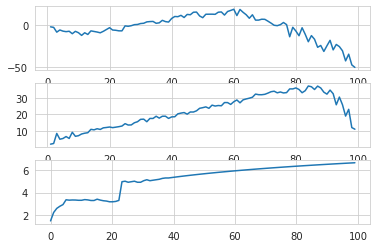

The fit is -67.973781 x^2 + 776.278915 x + -2199.335426
The chi squared is 1126.442974


array([  -67.97378116,   776.27891529, -2199.33542636])

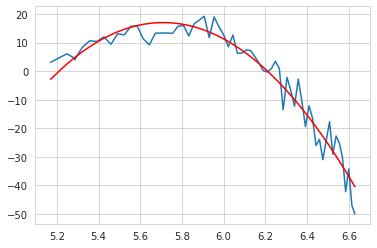

In [13]:
Einstein('barabasi')

Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvature (augmented) computation done.
Forman curvat

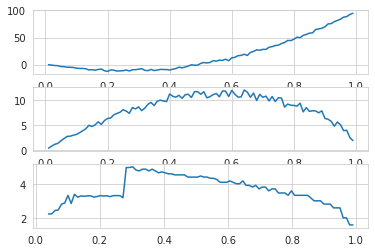

The slope is 38.585446
The value of r squared is 0.980310


[38.5854458579381, 0.9803101475175791]

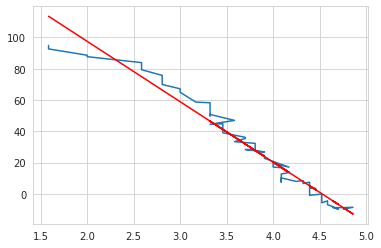

In [14]:
Einstein('erdos')